# Hw1: 星星與銀河的分類（Star and galaxy）

1. 使用 RandomForestClassifier 的準確度（accuracy） (3%/15%) [需附上已經有跑出結果的程式碼]
2. 使用 SimpleNeuralNetwork 的準確度（accuracy） (3%/15%) [需附上已經有跑出結果的程式碼]
3. 請說明 RandomForestClassifier 的分類原理 (3%/15%)
4. 請說明 SimpleNeuralNetwork 的分類原理 (3%/15%)
5. 請選擇其中一種分類法，提升其準確度（accuracy）(2%/15%)，並說明你如何提升(1%/15%)

### 載入數據

In [11]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

# 定義數據的資料夾
train_data_dir = "./Cutout Files"

# 用於預處理的影像轉換（調整大小 (resize) 和標準化 (normalize)）
image_size = (128, 128)  # 自行定義影像大小
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Grayscale(num_output_channels=1),  # 將影像轉換為單通道灰度圖
    transforms.ToTensor(),  # 將影像轉換為 PyTorch tensor
])

# 使用 ImageFolder 載入資料集（按子資料夾名稱組織）
train_dataset = ImageFolder(root=os.path.join(train_data_dir), transform=transform)

# 使用 DataLoader 建立批次並打亂資料集
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 檢查資料集類別（應為“galaxy”和“star”）
print(train_dataset.classes)
print("-"*30)

# 歷遍整個數據集
for images, labels in train_loader:
    print(f'一批圖像的形狀: {images.shape}') # 代表 32 張圖像，每張圖像有 3 個顏色通道（RGB），每個通道的大小為 128x128 像素。
    print(f'一批標籤: : {labels}') #一批 32 張圖片的對應類別標籤 （ 0 代表 galaxy，1 代表 star）
    break


['galaxy', 'star']
------------------------------
一批圖像的形狀: torch.Size([32, 1, 128, 128])
一批標籤: : tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0])


# 查看資料夾裡面的影像

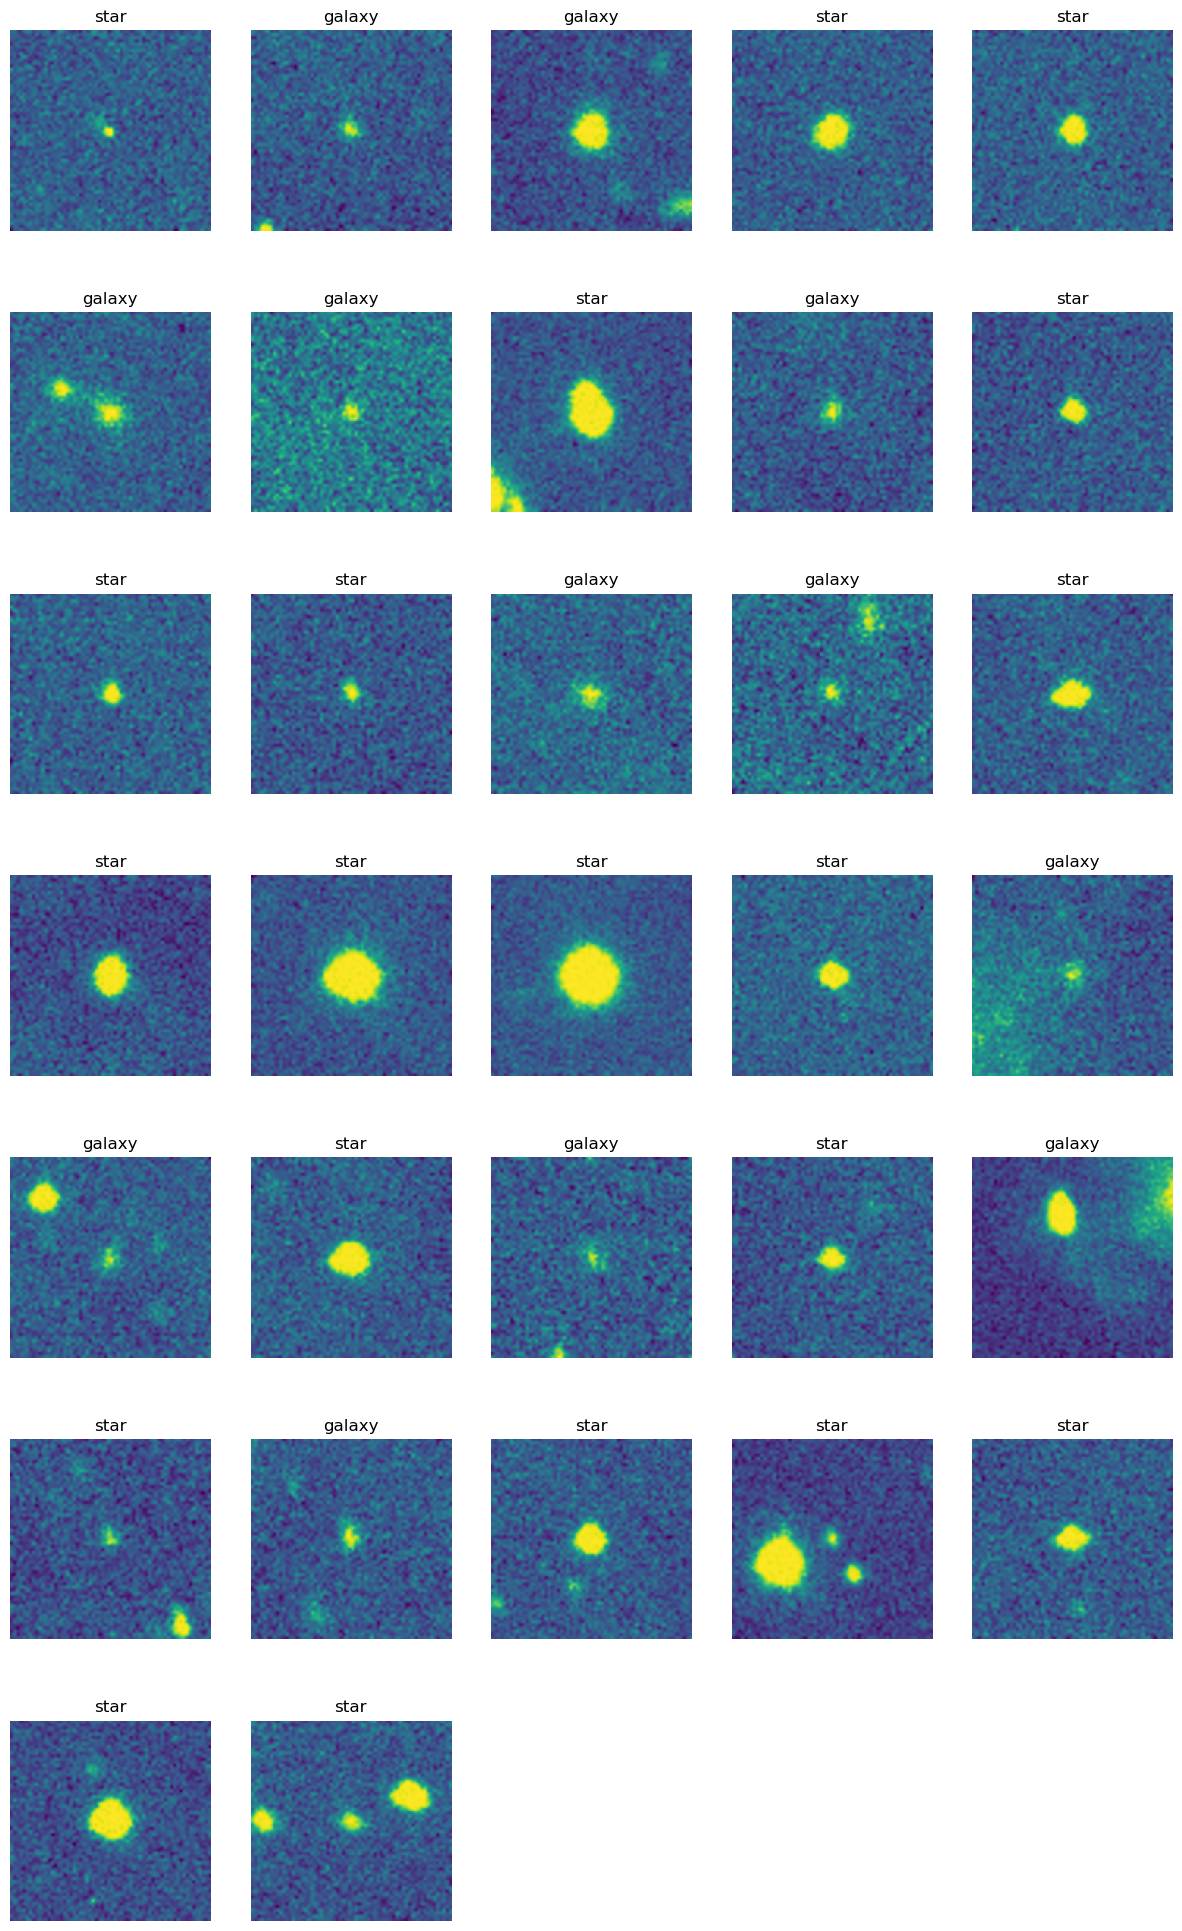

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(15, 25))
class_names = train_dataset.classes
data_iter = iter(train_loader)
images, labels = next(data_iter)


# 畫出前 32 張影像
for i in range(32):
    plt.subplot(7, 5, i + 1)
    
    # 將 tensor 轉換為 numpy 並轉換為 uint8 以便繪圖
    img = images[i].squeeze(0).numpy()  # 去掉不必要的通道維度，因為是單通道
    img = (img * 255).astype(np.uint8)  # 將範圍 [0, 1] 轉換為 [0, 255]
    
    plt.imshow(img)
    plt.title(class_names[labels[i].item()])  # 取得類別名稱
    plt.axis("off")

plt.show()


## 使用 隨機森林分類器
### 載入所需要的套件

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### 歷遍整個數據集並提取特徵

In [14]:
# 提取數據和標籤進行隨機森林訓練
X = []
y = []

for images, labels in train_loader:
    # 將每張影像展平成一維向量
    flattened_images = images.view(images.size(0), -1).numpy()
    X.extend(flattened_images)
    y.extend(labels.numpy())

# 將特徵和標籤轉換為 numpy 陣列
X = np.array(X)
y = np.array(y)

In [15]:
# 將數據拆分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

3188
798
3188
798


### 訓練隨機森林分類器


In [16]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 進行預測並評估模型性能
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"模型準確度: {accuracy * 100:.2f}%")

模型準確度: 82.58%


## 使用簡易的神經網路
### 載入所需要的套件

In [17]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

### 定義簡單的神經網路模型

In [18]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # 第一個全連接層
        self.relu = nn.ReLU()  # 激活函數
        self.fc2 = nn.Linear(hidden_size, num_classes)  # 輸出層

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


### 定義模型參數

In [19]:
input_size = 128 * 128  # 每張圖像扁平化後有 128*128 個像素
hidden_size = 256  # 隱藏層神經元數量
num_classes = 2  # galaxy 和 star 兩個類別
num_epochs = 10  # 訓練迭代次數
learning_rate = 0.001  # 學習率

# 初始化模型
model = SimpleNN(input_size, hidden_size, num_classes)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()  # 交叉熵損失函數
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 將模型移至 GPU（如果可用）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

SimpleNN(
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

### 訓練模型

In [20]:
for epoch in range(num_epochs):
    for images, labels in train_loader:
        # 將圖像展平成一維向量，並移至 GPU（如果可用）
        images = images.view(images.size(0), -1).to(device)
        labels = labels.to(device)

        # 前向傳播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向傳播和優化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.6303
Epoch [2/10], Loss: 0.4046
Epoch [3/10], Loss: 0.5731
Epoch [4/10], Loss: 0.4919
Epoch [5/10], Loss: 0.5065
Epoch [6/10], Loss: 0.8862
Epoch [7/10], Loss: 0.5096
Epoch [8/10], Loss: 0.4474
Epoch [9/10], Loss: 0.3729
Epoch [10/10], Loss: 0.5569


### 評估模型準確度

In [21]:
def evaluate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.view(images.size(0), -1).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'準確度: {accuracy:.2f}%')
    model.train()

# 用於測試的 DataLoader（將部分數據分離作為測試集）
train_data, test_data = train_test_split(train_dataset, test_size=0.2, random_state=42)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 評估模型
evaluate_accuracy(test_loader, model)

準確度: 76.19%
